## Classification using CNN

In [298]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb

#### `1. Data Loading and Preprocessing`

In [299]:
path_to_mnist = "../../data/external/double_mnist"

def load_mnist_data(path_to_data):
    """
    Load the MNIST data into train, validation and test sets.
    Takes in the path to the data and returns the data in the following format:
    (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)
    where train_data, val_data and test_data are numpy arrays of images 
    and train_labels, val_labels and test_labels are numpy arrays of labels.
    """
    def load_images_from_folder(folder_path, label_function):
        data = []
        labels = []
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):

                label = label_function(subfolder)
                
                for img_name in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img_name)
                    if img_path.endswith('.png') or img_path.endswith('.jpg'):
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            data.append(img)
                            labels.append(label)
        return np.array(data), np.array(labels)

    def count_digits_in_name(folder_name):
        if folder_name == '0':
            return 0
        return sum(c.isdigit() for c in folder_name)
    
    train_path = os.path.join(path_to_data, 'train')
    val_path = os.path.join(path_to_data, 'val')
    test_path = os.path.join(path_to_data, 'test')
    
    train_data, train_labels = load_images_from_folder(train_path, count_digits_in_name)
    val_data, val_labels = load_images_from_folder(val_path, count_digits_in_name)
    test_data, test_labels = load_images_from_folder(test_path, count_digits_in_name)
    
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

path_to_mnist = "../../data/external/double_mnist"
train_set, val_set, test_set = load_mnist_data(path_to_data=path_to_mnist)
print(f"Loaded {len(train_set[0])} train images, {len(val_set[0])} validation images, {len(test_set[0])} test images.")


Loaded 12600 train images, 3000 validation images, 4600 test images.


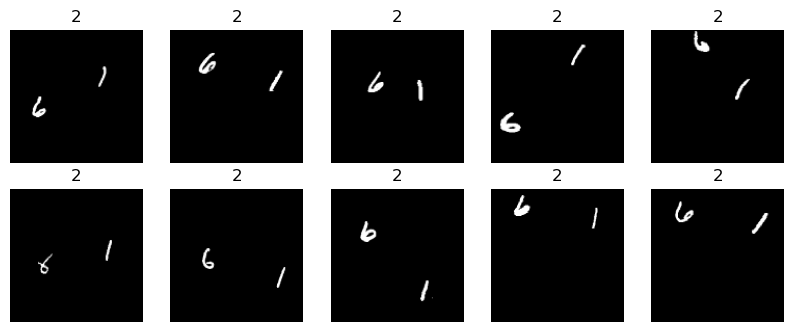

In [300]:
# checking if the data is loaded correctly by displaying some images

def display_images(images, labels, n_images):
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'{labels[i]}')
        plt.axis("off")
    plt.show()

# display_images(train_set[0], train_set[1], 10)
display_images(val_set[0], val_set[1], 10)
# display_images(test_set[0], test_set[1], 10)


In [301]:
"""
MultiMNISTDataset class - inherited from torch.utils.data.Dataset 
and __len__ and __getitem__ functions are overridden.
"""

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [334]:
# np array -> pil image -> resize -> tensor

def load_data(task, shuffle=True):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    train_dataset = MultiMNISTDataset(train_set[0], train_set[1], transform=transform)
    val_dataset = MultiMNISTDataset(val_set[0], val_set[1], transform=transform)
    test_dataset = MultiMNISTDataset(test_set[0], test_set[1], transform=transform)

    if task == 'classification':
        # labels are tensors -> long
        train_dataset.labels = torch.tensor(train_dataset.labels).long()
        val_dataset.labels = torch.tensor(val_dataset.labels).long()
        test_dataset.labels = torch.tensor(test_dataset.labels).long()

    else:
        # labels are tensors -> float
        train_dataset.labels = torch.tensor(train_dataset.labels).float()
        val_dataset.labels = torch.tensor(val_dataset.labels).float()
        test_dataset.labels = torch.tensor(test_dataset.labels).float()

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader, test_loader

Note:
The images have been converted to gray scale and resized to 64x64 from the original 128x128. This is done to reduce the training time.

#### `2. Implement the CNN Class`

In [303]:
class CNN(nn.Module):
    """
    CNN class - inherited from torch.nn.Module
    Hnadles regression and classification tasks.
    Contains convolutional layers and fully connected layers.
    Also contains forward function to define the forward pass.
    """
    def __init__(self, task='classification', dropout_prob=0.5):
        super(CNN, self).__init__()

        if task != 'classification' and task != 'regression':
            raise ValueError("Task must be either 'classification' or 'regression'")

        self.task = task
        self.dropout_prob = dropout_prob

        # architecture 1
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # 64x64 -> 32x32 after pooling
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x32 -> 16x16 after pooling
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 16x16 -> 8x8 after pooling

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=128)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(in_features=128, out_features=1 if task == 'regression' else 4)
        # 1 output for regression, 4 for classification (0, 1, 2, 3)

        #----------------------------------------------#

        # # architecture 2
        # # Convolutional layers
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # 64x64 -> 32x32 after pooling
        # self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x32 -> 16x16 after pooling
        # # Fully connected layer
        # self.fc1 = nn.Linear(in_features=32 * 16 * 16, out_features=64)
        # self.fc1_drop = nn.Dropout(p=dropout_prob)
        # self.fc2 = nn.Linear(in_features=64, out_features=1 if task == 'regression' else 4)

        #----------------------------------------------#


    def forward(self, x):

        feature_maps = []

        # conv1 -> relu -> maxpool
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        feature_maps.append(x)

        # conv2 -> relu -> maxpool
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        feature_maps.append(x)
        
        # comment out the following lines for architecture 2
        # conv3 -> relu -> maxpool
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        feature_maps.append(x)

        # flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # fc1 -> relu -> fc2
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return x, feature_maps

        

Note:
For Cross Entropy Loss, we use `torch.nn.CrossEntropyLoss()` which has 2 types of formats for target labels:
1. integer based target labels
2. probability based target labels (one-hot encoded)

Here we are using integer based target labels, so the expected output from the model should be integer based labels. So, we are using `torch.max()` to get the index of the maximum value in the output tensor. Here long() is used to convert the index to integer type.

In case of probability based target labels, we need to have a softmax layer at the end of the model to convert the output to probability based labels. In this case, float() is used to convert the index to float type.

In [304]:
def train(model, train_loader, val_loader, optimizer, num_epochs, 
          device, task='classification', wandb_flag=False, epoch_logging=True):
    
    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()

    old_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # intialize the gradients to zero
            optimizer.zero_grad()

            # forward pass
            outputs, _ = model(inputs)
            
            if task == 'regression':
                outputs = outputs.view(-1)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass
            loss.backward()

            # update the weights
            optimizer.step()

            train_loss += loss.item()            

        # validation loss
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass
                outputs, _ = model(inputs)

                if task == 'regression':
                    outputs = outputs.view(-1)

                # val loss
                loss = criterion(outputs, labels)

                old_val_loss = val_loss
                val_loss += loss.item()

        if epoch_logging:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

        if wandb_flag:
            wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})

        if np.abs(val_loss - old_val_loss) < 1e-5:
            if epoch_logging:
                print("No improvement in validation loss. Stopping training.")
            break
        

In [305]:
def train_driver(
        task, 
        num_epochs=10, 
        optimizer_type='adam', 
        device=None, lr=0.001, 
        dropout_prob=0.5, 
        wandb_flag=False, 
        epoch_logging=True):
    
    if task == 'classification':
        model = CNN(task='classification', dropout_prob=dropout_prob).to(device)
        if optimizer_type == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_type == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr)
        train_loader, val_loader, test_loader = load_data(task='classification')
        train(model, train_loader, val_loader, optimizer, num_epochs=num_epochs, 
              device=device, task='classification', wandb_flag=wandb_flag, epoch_logging=epoch_logging)
        return model, val_loader, test_loader
    else:
        model = CNN(task='regression', dropout_prob=dropout_prob).to(device)
        if optimizer_type == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_type == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr)
        train_loader, val_loader, test_loader = load_data(task='regression')
        train(model, train_loader, val_loader, optimizer, num_epochs=num_epochs, 
              device=device, task='regression', wandb_flag=wandb_flag, epoch_logging=epoch_logging)
        return model, val_loader, test_loader
    

In [306]:
# testing the model
# accuracy is calculated as #correct predictions / #total predictions

def test_model(model, test_loader, device, task='classification', logging=True):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, _ = model(inputs)

            if task == 'regression':
                outputs = outputs.view(-1)
                
                # if regression, we need to round the output to the nearest integer
                outputs = torch.round(outputs)

                total += labels.size(0)
                correct += (outputs == labels).sum().item()

            else:
                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy}")
    return accuracy


In [307]:
# display some predictions - visualizing the model's output

def display_predictions(model, test_loader, device, n_images=5, task='classification'):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, _ = model(inputs)

            if task == 'regression':
                outputs = outputs.view(-1)
                predicted = torch.round(outputs)
            else:
                _, predicted = torch.max(outputs, dim=1)

            plt.figure(figsize=(15, 5))
            for i in range(n_images):
                ax = plt.subplot(1, n_images, i + 1)
                plt.imshow(inputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title(f"Actual: {labels[i]}, Predicted: {predicted[i]}")
                plt.axis("off")
            plt.show()
            break


Epoch 1/10, Train Loss: 0.16370293737975952, Val Loss: 0.0038154876251900666
Epoch 2/10, Train Loss: 0.007448388585685118, Val Loss: 0.0007311958165410806
Epoch 3/10, Train Loss: 0.003568769475970936, Val Loss: 0.0009910585058493775
Epoch 4/10, Train Loss: 0.007374575160402945, Val Loss: 0.00023006981112174836
No improvement in validation loss. Stopping training.
Classification model training complete.

Evaluating the model on the validation set.
Accuracy: 1.0

Evaluating the model on the test set.
Accuracy: 1.0


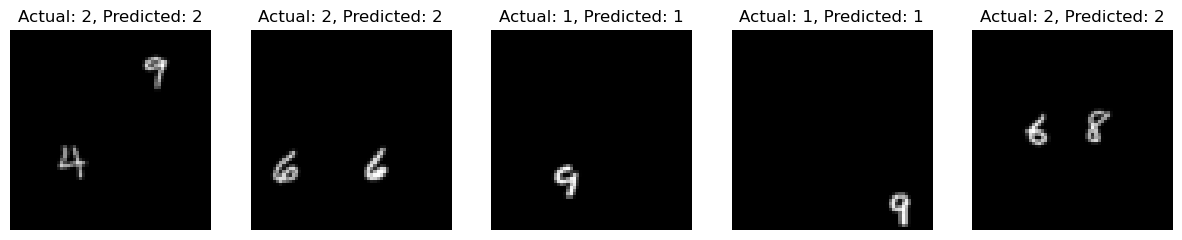

In [370]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_classification, val_loader, test_loader = train_driver(task='classification', num_epochs=10, optimizer_type='adam',
                                                              lr=0.001, device=device, dropout_prob=0.3)

print("Classification model training complete.")

print("\nEvaluating the model on the validation set.")
test_model(model_classification, val_loader, device, task='classification')

print("\nEvaluating the model on the test set.")
test_model(model_classification, test_loader, device, task='classification')

display_predictions(model_classification, test_loader, device, n_images=5, task='classification')

Epoch 1/10, Train Loss: 0.18851087807776964, Val Loss: 0.016326389359706577
Epoch 2/10, Train Loss: 0.0630911892175977, Val Loss: 0.07009500915065725
Epoch 3/10, Train Loss: 0.06001334238400314, Val Loss: 0.01917777257040143
Epoch 4/10, Train Loss: 0.05244260985252972, Val Loss: 0.006555424339355941
Epoch 5/10, Train Loss: 0.048989530071275794, Val Loss: 0.01627224283491043
Epoch 6/10, Train Loss: 0.04473854518178756, Val Loss: 0.01299322190436911
Epoch 7/10, Train Loss: 0.04206843183702094, Val Loss: 0.008360115357952074
Epoch 8/10, Train Loss: 0.036466229456443774, Val Loss: 0.019198712486615206
Epoch 9/10, Train Loss: 0.03596861917657901, Val Loss: 0.005346773269071066
Epoch 10/10, Train Loss: 0.035312712001070605, Val Loss: 0.008843967208064142
Regression model training complete.

Evaluating the model on the validation set.
Accuracy: 1.0

Evaluating the model on the test set.
Accuracy: 1.0


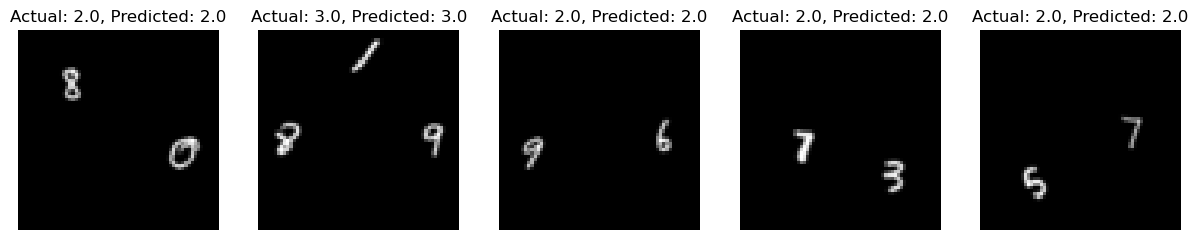

In [309]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_regression, val_loader, test_loader = train_driver(task='regression', num_epochs=10, optimizer_type='adam',
                                                          lr=0.001, device=device, dropout_prob=0.3)

print("Regression model training complete.")

print("\nEvaluating the model on the validation set.")
test_model(model_regression, val_loader, device, task='regression')

print("\nEvaluating the model on the test set.")
test_model(model_regression, test_loader, device, task='regression')

display_predictions(model_regression, test_loader, device, n_images=5, task='regression')

#### `3. Hyperparameter Tuning`

Hyperparameter tuning for the CNN model
1. learning rate
2. optimizer
3. dropout rate
4. convolutional layers

The names of the runs start with 1 or 2
- 1 for the CNN architecture 1:
3 convolutional layers with 32, 64, 128 filters respectively, each followed by a max pooling layer, and a fully connected layer with 128 neurons. The activation function is ReLU.

- 2 for the CNN architecture 2:
4 convolutional layers with 32, 64, 128, 256 filters respectively, each followed by a max pooling layer, and a fully connected layer with 128 neurons. The activation function is ReLU.

The CNN class is changed to incorporate the 2 architectures. The plots for train_loss, train_accuracy, val_loss, val_accuracy are plotted for each run (refer to wandb link below)

In [310]:
def sweep_train():
    with wandb.init() as run:
        config = run.config
        wandb.run.name = f"2_{config.task}_{config.optimizer_type}_{config.lr}_{config.dropout_prob}"
        model, val_loader, test_loader = train_driver(
            task=config.task, 
            num_epochs=10, 
            optimizer_type=config.optimizer_type,
            lr=config.lr, 
            device=device, 
            dropout_prob=config.dropout_prob, 
            wandb_flag=True,
            epoch_logging=False
        )
        
        val_acc = test_model(model, val_loader, device, task=config.task, logging=False)
        test_acc = test_model(model, test_loader, device, task=config.task, logging=False)

        wandb.log({"val_acc": val_acc, "test_acc": test_acc})


def hyperparameter_tuning():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'task': {
                'values': ['classification', 'regression']
            },
            'optimizer_type': {
                'values': ['adam', 'sgd']
            },
            'lr': {
                'values': [0.001, 0.01]
            },
            'dropout_prob': {
                'values': [0.3, 0.5]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='SMAI_ASG_4_CNN')
    wandb.agent(sweep_id, function=sweep_train)

In [311]:
# hyperparameter_tuning()

[WandB Link](https://wandb.ai/abhinav7/SMAI_ASG_4_CNN)

<div style="display: flex; justify-content: space-between;">

<div style="width: 45%;">

### Classification
**Best Model**:  
  - CNN Architecture 1  
  - Learning Rate: 0.001  
  - Optimizer: Adam  
  - Dropout Rate: 0.3  
  - Validation Accuracy: 1  
  - Test Accuracy: 1  
  - Validation Loss: 0.00007  
  - Train Loss: 0.0016  

</div>

<div style="width: 45%;">

### Regression
**Best Model**:  
  - CNN Architecture 1  
  - Learning Rate: 0.001  
  - Optimizer: Adam  
  - Dropout Rate: 0.3  
  - Validation Accuracy: 1  
  - Test Accuracy: 1  
  - Validation Loss: 0.0005  
  - Train Loss: 0.004  

</div>

</div>


#### `4. Feature map Visualization`

In [368]:
def visualize_feature_maps(feature_num=0):
    train_loader, val_loader, test_loader = load_data(task='classification', shuffle=False)

    model_classification.eval()

    with torch.no_grad():
        
        # iterate through the first batch
        inputs, labels = next(iter(train_loader))
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, feature_maps = model_classification(inputs)

        _, predicted = torch.max(outputs, dim=1)

        indices = [0, 12, 21]

        for i in indices:

            plt.figure(figsize=(25, 10))
            plt.subplot(1, len(feature_maps) + 1, 1)
            # original image
            # .cpu() -> move tensor to cpu for numpy conversion
            # .squeeze() -> remove the channel dimension
            plt.imshow(inputs[i].cpu().squeeze(), cmap='gray')
            plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
            plt.axis('off')

            # 3 feature maps - one per convolutional layer
            for layer_index, fmap in enumerate(feature_maps):
                # .cpu() -> move tensor to cpu for numpy conversion
                # .detach() -> detach the tensor from the computation graph
                fmap = fmap[i].cpu().detach()
                # print(f"Layer {layer_index + 1} shape: {fmap.shape}")
                num_filters = fmap.shape[0]

                plt.subplot(1, len(feature_maps) + 1, layer_index + 2)
                # fmap[0] first filter of each feature map displayed for simplicity
                # a colormap is used to visualize better
                plt.imshow(fmap[feature_num], cmap='inferno')
                plt.title(f'Layer {layer_index + 1}')
                plt.axis('off')

            plt.show()



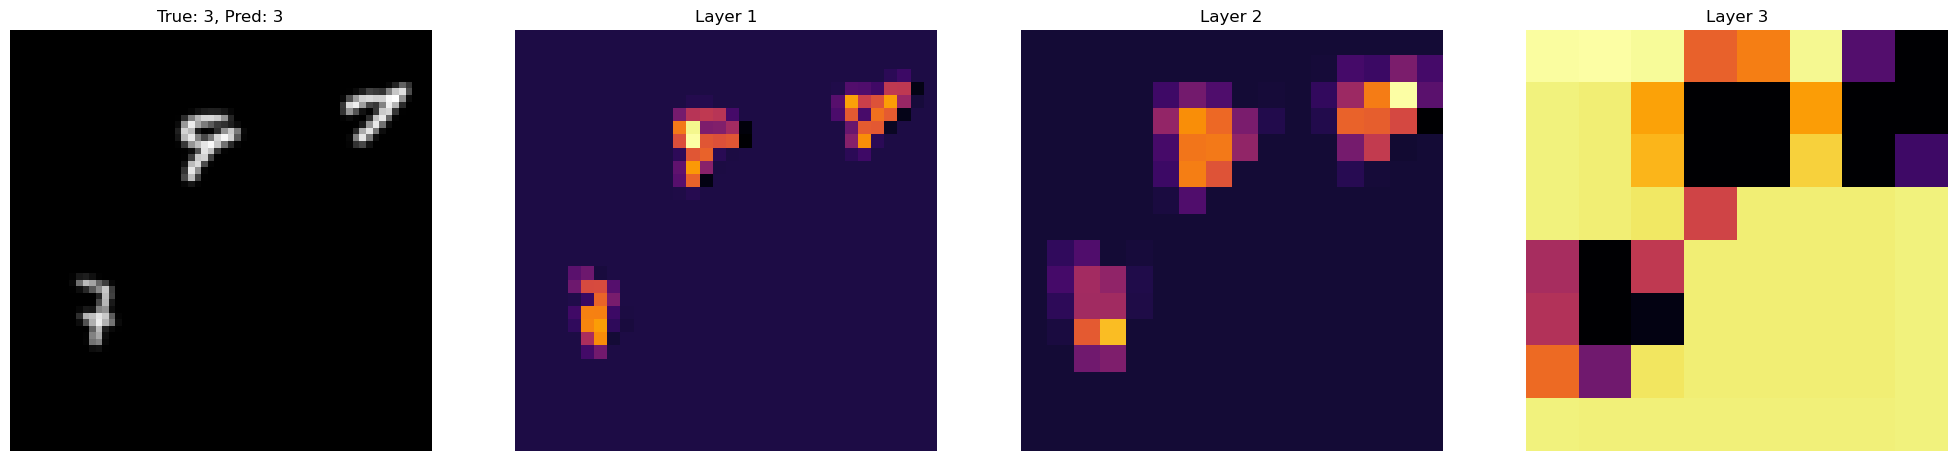

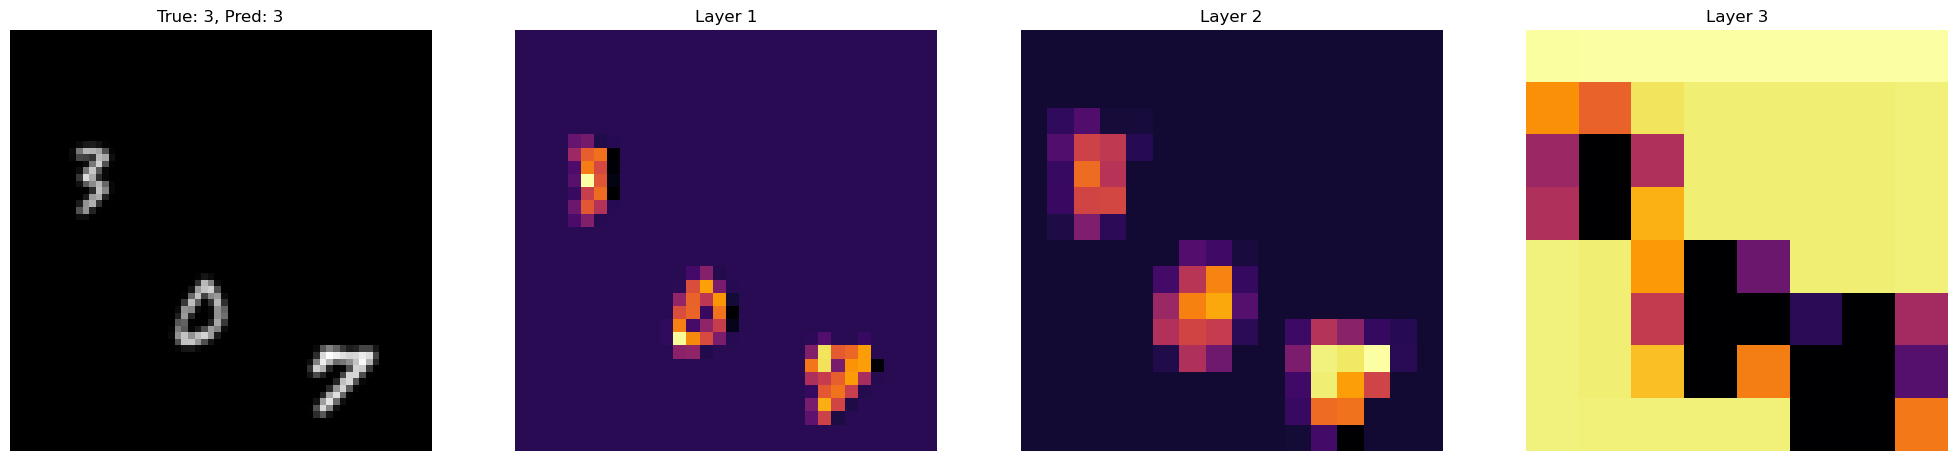

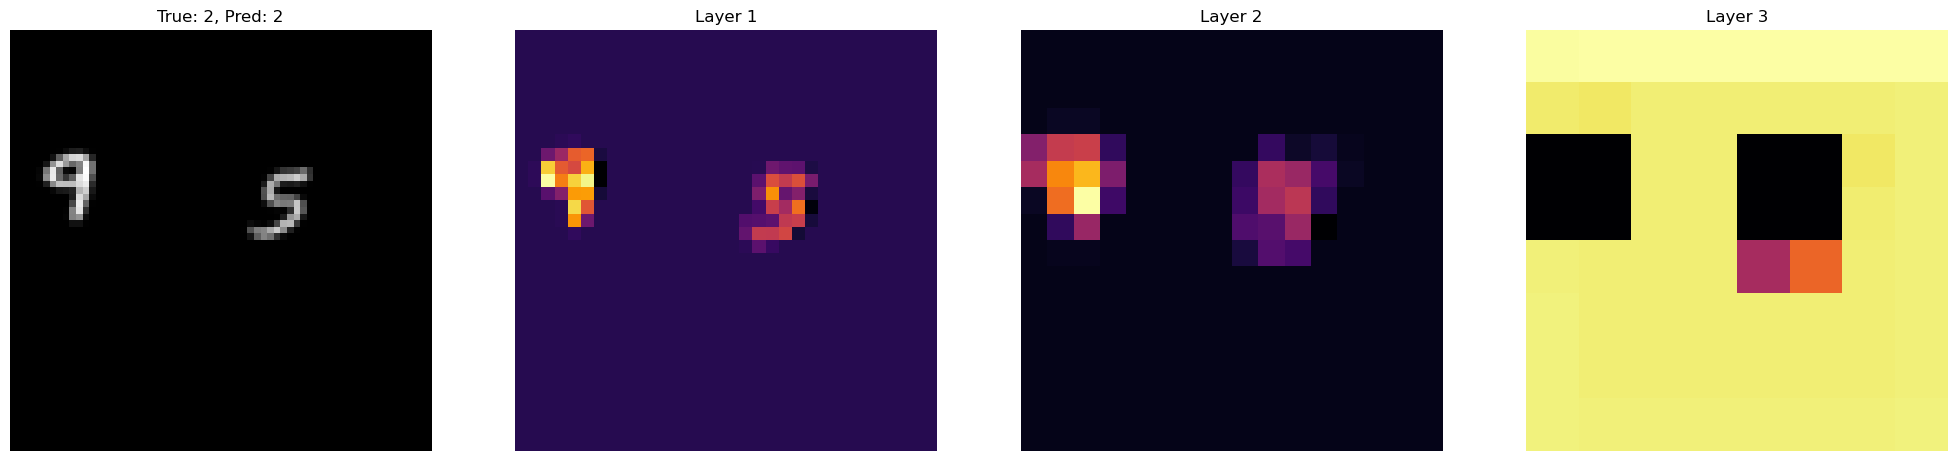

In [369]:
visualize_feature_maps(feature_num=0)

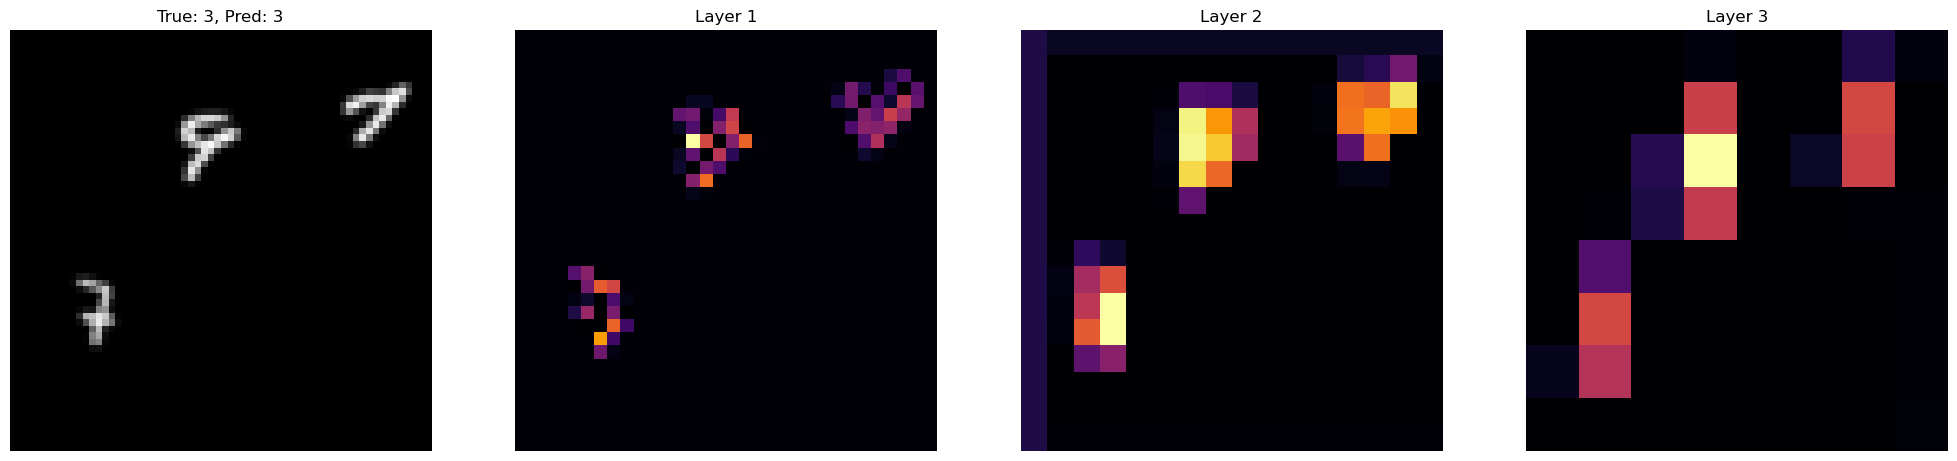

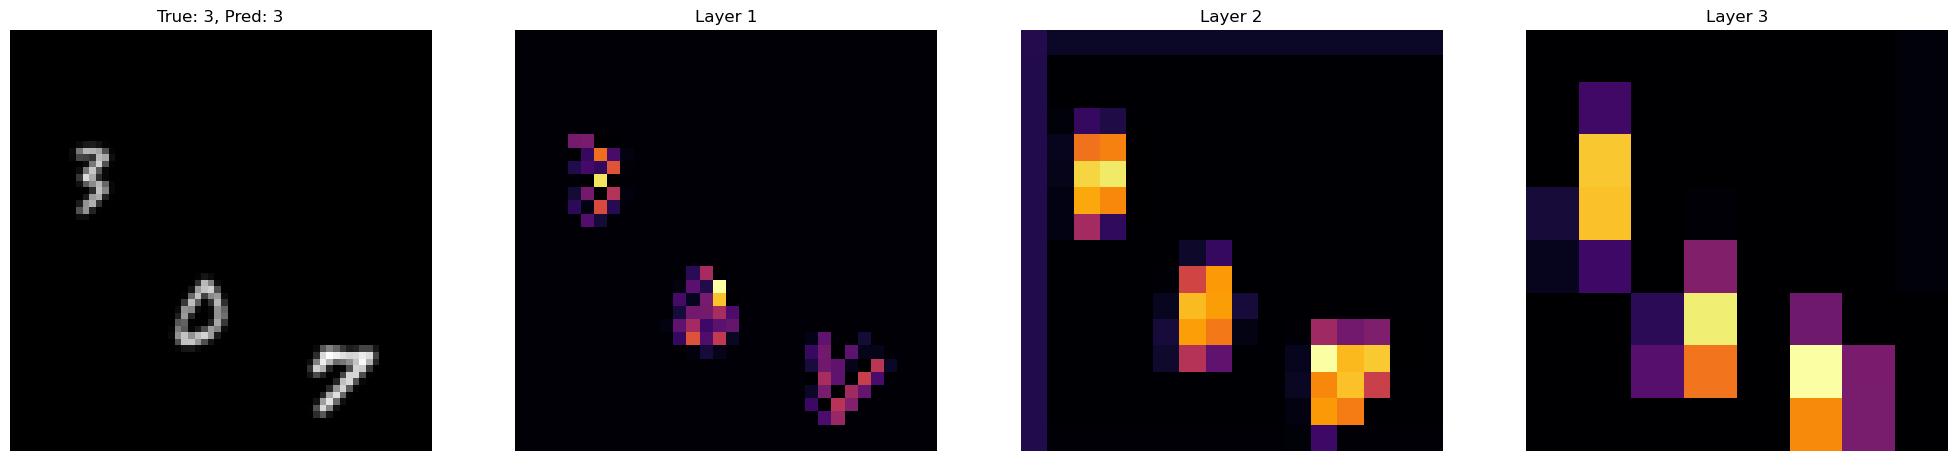

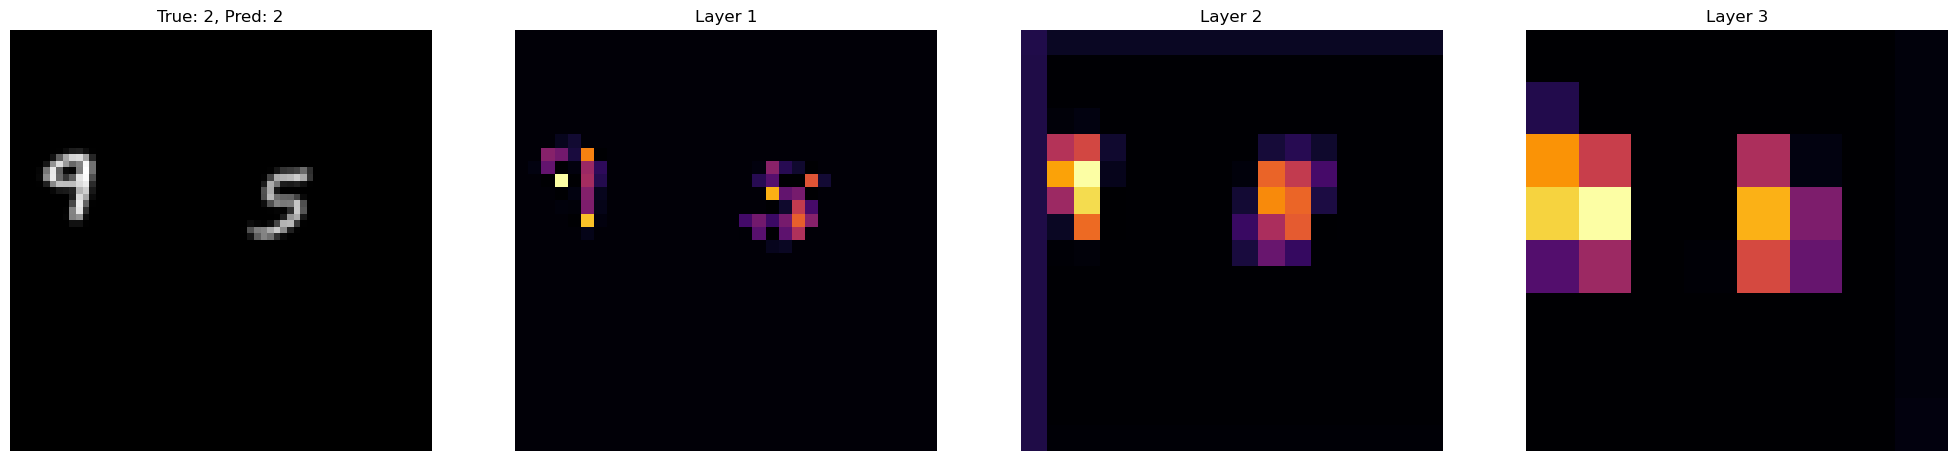

In [364]:
visualize_feature_maps(feature_num=6)

Note: Inputs are scaled images of size 64x64 (hence they appear blurry)

The next 3 images are the feature maps of the 3 convolutional layers of the CNN architecture 1. 

The first image shows the feature maps corresponding to the zeroth filter, the second image shows the feature maps corresponding to the 6th filter.

At the 1st layer, the number of filters is less (16) and the feature maps are not very detailed. They extract broader features from the image like shape, texture, edges. Notice we can still see the edges of the digits in the feature maps of the 1st layer. For eg: the digits digits like 0, 6, 8 and 9 have circular edges whereas the digits 1 and 7 have straight edges and the feature maps of the 1st layer try to capture these edges.

As we go deeper in the network, the number of filters increases and the feature maps become more detailed. They extract more specific features from the image. 

For eg: at the 3rd layer, the number of filters increases to 64 and the feature maps are detailed. They extract more specific features from the image. Its not clear from the above images, because it just shows one of the feature maps from each layer. The aggregate of all the feature maps from the 3rd layer will together hold all the information of each digit.